# Teen E-Cig Use: Classification

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, fbeta_score, make_scorer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

import gc

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

## Importing data 

In [2]:
# importing cleaned data from notebook #1 
# the ecig_df was not altered in notebook #2 (EDA) 

ecig_df = pd.read_csv('ecig_df.csv')
ecig_df.head()

,e_cig,smoke_cig,cigar,other_tob,vape_mj,grade,sex,native,asian,black,pac_island,white,hispanic,internet_ads,TV/stream_ads,social_ads,internet_use,TV/stream_use,social_use,addictive,harm_self,harm_others,real_cost,health_seen,health_asked,tob_home
0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4.0,3.0,2.0,1.0,1.0,1.0,1.0,4.0,4.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,-1.0,2.0,1.0,1.0,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,9.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,4.0,1.0,1.0,1.0,1.0,4.0,4.0,1.0,1.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,9.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,3.0,1.0,1.0,1.0,0.0,3.0,3.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [3]:
# over 13K student participants and 26 rows

ecig_df.shape

(13114, 26)

## Baseline model

### Set-up modeling 

In [4]:
X = ecig_df.iloc[:, 1:]
y = ecig_df['e_cig']

In [5]:
# create a hold-out (testing) set containing 20% of the data

X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

### Baseline modeling (KNN)

In [6]:
# will be using a small number of features for baseline model

X_small = X.iloc[:, :5]
X_test_small = X_test.iloc[:, :5]

X_small.head()

,smoke_cig,cigar,other_tob,vape_mj,grade
1611,0.0,0.0,0.0,0.0,8.0
8987,0.0,0.0,1.0,0.0,9.0
7252,0.0,0.0,0.0,0.0,9.0
337,0.0,0.0,1.0,1.0,11.0
12921,0.0,0.0,0.0,0.0,11.0


In [7]:
# get baseline model using knn with 5 nearest neighbors

# first scale our training data
std_scale = StandardScaler()
X_sm_scaled = std_scale.fit_transform(X_small)

# fit knn model on training 
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_sm_scaled, y)

# score training data
y_pred = knn.predict(X_sm_scaled)
print(f'Baseline accuracy: {accuracy_score(y, y_pred)}')
print(f'Baseline precision: {precision_score(y, y_pred)}')
print(f'Baseline recall: {recall_score(y, y_pred)}')
print(f'Baseline F1 score: {f1_score(y, y_pred)}')
print(f'Baseline F2 score: {fbeta_score(y, y_pred, beta=2)}')

Baseline accuracy: 0.8432942522161853
Baseline precision: 0.7275949367088608
Baseline recall: 0.5650806134486827
Baseline F1 score: 0.6361221779548473
Baseline F2 score: 0.5915040750802667


In [8]:
# get baseline on the hold-out (test) data

# scale testing data
X_test_sm_scaled = std_scale.transform(X_test_small)

# score testing data
y_pred_test = knn.predict(X_test_sm_scaled)
print(f'Baseline accuracy: {accuracy_score(y_test, y_pred_test)}')
print(f'Baseline precision: {precision_score(y_test, y_pred_test)}')
print(f'Baseline recall: {recall_score(y_test, y_pred_test)}')
print(f'Baseline F1 score: {f1_score(y_test, y_pred_test)}')
print(f'Baseline F2 score: {fbeta_score(y_test, y_pred_test, beta=2)}')

Baseline accuracy: 0.8387342737323675
Baseline precision: 0.7398373983739838
Baseline recall: 0.5523520485584219
Baseline F1 score: 0.63249348392702
Baseline F2 score: 0.5818414322250639


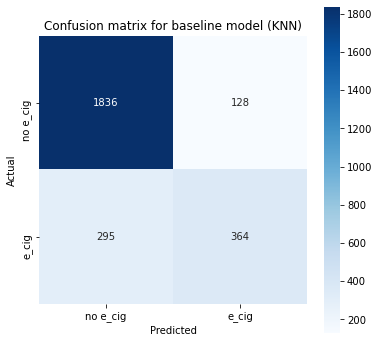

In [9]:
# create a confusion matrix for baseline model - using hold-out (test) data

base_confusion = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,6))
sns.heatmap(base_confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=['no e_cig', 'e_cig'],
           yticklabels=['no e_cig', 'e_cig'],
           fmt='0.0f')
plt.xlabel('Predicted')
plt.ylabel('Actual');
plt.title('Confusion matrix for baseline model (KNN)');

## Expand & refine model 

### KNN with CV & all features

In [10]:
# knn function w/ 10-fold CV and using all 25 features

def knn(X, y, n_neighbors):
    X, y = np.array(X), np.array(y)
    kf = KFold(n_splits=10, shuffle=True, random_state=10)
    cv_F2s = []

    # kf.split returns the indeces for the rows in train and val
    for train_index, val_index in kf.split(X,y):

        X_train, y_train = X[train_index], y[train_index]
        X_val, y_val = X[val_index], y[val_index]

        # first scale features
        scalar = StandardScaler()
        X_train = scalar.fit_transform(X_train)
        X_val = scalar.transform(X_val)

        #train model
        model = KNeighborsClassifier(n_neighbors=n_neighbors)
        model.fit(X_train, y_train)

        # generate F2 score
        y_pred_val = model.predict(X_val)
        cv_F2s.append(fbeta_score(y_val, y_pred_val, beta=2))
        
    #print(f'Simple scores: {cv_F2s} \n')
    print(f'10-fold CV mean F2 score: {np.mean(cv_F2s):.3f} +/- {np.std(cv_F2s):.3f}')

In [11]:
# F2 score is similar to baseline

knn(X, y, n_neighbors=5)

10-fold CV mean F2 score: 0.579 +/- 0.028


In [12]:
# actually worse if increase # of neighbors

knn(X, y, n_neighbors=10)

10-fold CV mean F2 score: 0.545 +/- 0.030


### Logistic regression with CV & all features

In [13]:
# logistic regression function w/ 10-fold CV and all 25 features

def logistic_reg(X, y, C=1, class_weight=None):
    X, y = np.array(X), np.array(y)
    kf = KFold(n_splits=10, shuffle=True, random_state=10)
    cv_F2s = []

    # kf.split returns the indeces for the rows in train and val
    for train_index, val_index in kf.split(X,y):

        X_train, y_train = X[train_index], y[train_index]
        X_val, y_val = X[val_index], y[val_index]

        # first scale features
        scalar = StandardScaler()
        X_train = scalar.fit_transform(X_train)
        X_val = scalar.transform(X_val)

        #train model
        model = LogisticRegression(C=C, class_weight=class_weight, solver='liblinear')
        model.fit(X_train, y_train)

        # generate hard probabilities and F2 score
        y_pred_val = model.predict(X_val)
        cv_F2s.append(fbeta_score(y_val, y_pred_val, beta=2))
        
    #print(f'Simple scores: {cv_F2s} \n')
    print(f'10-fold CV mean F2 score: {np.mean(cv_F2s):.3f} +/- {np.std(cv_F2s):.3f}')
    return model

In [14]:
# running vanilla logistic function and saving the fitted model

lm = logistic_reg(X, y)

10-fold CV mean F2 score: 0.603 +/- 0.026


### Random forest with CV & all features 

In [15]:
def random_forest(X, y):
    X, y = np.array(X), np.array(y)
    kf = KFold(n_splits=10, shuffle=True, random_state=10)
    cv_F2s = []

    for train_index, val_index in kf.split(X,y):
        X_train, y_train = X[train_index], y[train_index]
        X_val, y_val = X[val_index], y[val_index]

        # no need to scale features!
        
        #train model
        model = RandomForestClassifier(n_estimators=100)
        model.fit(X_train, y_train)

        # generate hard probabilities and F2 score
        y_pred_val = model.predict(X_val)
        cv_F2s.append(fbeta_score(y_val, y_pred_val, beta=2))
        
    #print(f'Simple scores: {cv_F2s} \n')
    print(f'10-fold CV mean F2 score: {np.mean(cv_F2s):.3f} +/- {np.std(cv_F2s):.3f}')

In [16]:
random_forest(X,y)

10-fold CV mean F2 score: 0.624 +/- 0.018


### XGBoost with CV & all features 

In [17]:
def XGBoost(X, y):
    X, y = np.array(X), np.array(y)
    kf = KFold(n_splits=10, shuffle=True, random_state=10)
    cv_F2s = []

    for train_index, val_index in kf.split(X,y):
        X_train, y_train = X[train_index], y[train_index]
        X_val, y_val = X[val_index], y[val_index]

        # no need to scale features!
        
        #train model
        model = xgb.XGBClassifier(n_estimators=10000,
                                  max_depth=8,
                                 objective='binary:logistic',
                                 learning_rate=.3,
                                 random_state=1,
                                 use_label_encoder=False)
        eval_set = [(X_train, y_train), (X_val, y_val)]
        model.fit(X_train, y_train,
                  eval_set=eval_set,
                  eval_metric='error',
                 early_stopping_rounds=20,
                 verbose=False)

        # generate hard probabilities and F2 score
        y_pred_val = model.predict(X_val)
        cv_F2s.append(fbeta_score(y_val, y_pred_val, beta=2))
        
    #print(f'Simple scores: {cv_F2s} \n')
    print(f'10-fold CV mean F2 score: {np.mean(cv_F2s):.3f} +/- {np.std(cv_F2s):.3f}')
    return model

In [18]:
XGBoost(X, y)

10-fold CV mean F2 score: 0.632 +/- 0.027


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10000, n_jobs=8, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

## Improving performance of logistic model 

- Have chosen to pursue a logistic model given it's interpretability - and since F2 scores are comparable to RF and XGBoost and better than KNN

### Weight the minority class 

In [19]:
# this time, weight the minority class (ecig use) 4x the majority (no use)
# better performance!

lm_weight = logistic_reg(X, y,
             class_weight={1 : 4, 0 : 1}) 

10-fold CV mean F2 score: 0.751 +/- 0.016


### Optimizing F2 score threshold 

In [20]:
# modify function to include adjustment of F2 score

def logistic_F2_adjuster(X, y, C=1, class_weight=None):
    X, y = np.array(X), np.array(y)
    kf = KFold(n_splits=10, shuffle=True, random_state=10)
    cv_best_F2s = []
    cv_best_thresholds = []
    for train_index, val_index in kf.split(X,y):

        X_train, y_train = X[train_index], y[train_index]
        X_val, y_val = X[val_index], y[val_index]

        # first scale features
        scalar = StandardScaler()
        X_train = scalar.fit_transform(X_train)
        X_val = scalar.transform(X_val)

        #train model
        model = LogisticRegression(C=C, class_weight=class_weight, solver='liblinear')
        model.fit(X_train, y_train)

        # generate hard probabilities and F2 score
        #y_pred_val = model.predict(X_val)
        
        # generate soft probabilities and thresholds
        thresh_ps = np.linspace(.10, .50, 100) # 100 point between 0.1 and 0.5
        model_val_probs = model.predict_proba(X_val)[:,1] # positive class probs
        f2_scores = []
        for p in thresh_ps:
            model_val_labels = model_val_probs >= p # for each value is the prob > threshold? 
            f2_scores.append(fbeta_score(y_val, model_val_labels, beta=2))
        cv_best_F2s.append(np.max(f2_scores))
        cv_best_thresholds.append(thresh_ps[np.argmax(f2_scores)])
        
    print(f'Best mean f2 score: {np.mean(cv_best_F2s):.3f}  +/- {np.std(cv_best_F2s):.3f} at mean prob decision threshold of {np.mean(cv_best_thresholds):.3f}')

In [21]:
# optimizing f2 decision score helped some more 

logistic_F2_adjuster(X, y,
             class_weight={1 : 4, 0 : 1}) 

Best mean f2 score: 0.773  +/- 0.011 at mean prob decision threshold of 0.366


### Optimizing parameter "C"  using GridSearchCV

In [22]:
# create a custom scorer for F2 in sklearn - can be used in GridSearchCV and CV

ftwo_scorer = make_scorer(fbeta_score, beta=2)

In [23]:
# we'll use C for grid parameter

C_range = list(range(1,1001, 20))
param_grid = dict(C=C_range)
print(param_grid)

{'C': [1, 21, 41, 61, 81, 101, 121, 141, 161, 181, 201, 221, 241, 261, 281, 301, 321, 341, 361, 381, 401, 421, 441, 461, 481, 501, 521, 541, 561, 581, 601, 621, 641, 661, 681, 701, 721, 741, 761, 781, 801, 821, 841, 861, 881, 901, 921, 941, 961, 981]}


In [24]:
# instantiate the grid and fit on training data

log_model = LogisticRegression(class_weight={1 : 4, 0 : 1}, 
                        solver='liblinear')
grid = GridSearchCV(log_model, param_grid, 
                    cv=10, scoring=ftwo_scorer)
grid.fit(X,y);

In [25]:
# complete results, sorted by rank

df_cv = pd.DataFrame(grid.cv_results_)
df_cv.sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
1,0.048173,0.002584,0.002886,0.000218,21,{'C': 21},0.757143,0.730825,0.774545,0.768956,0.744069,0.764239,0.76756,0.751258,0.719503,0.740741,0.751884,0.017055,1
2,0.045679,0.000916,0.002676,0.000029,41,{'C': 41},0.757143,0.730825,0.774545,0.768956,0.744069,0.764239,0.76756,0.751258,0.719503,0.740741,0.751884,0.017055,1
24,0.049034,0.002353,0.002989,0.000302,481,{'C': 481},0.757143,0.730825,0.774545,0.768956,0.744069,0.763689,0.76756,0.751258,0.719503,0.740741,0.751829,0.017016,3
28,0.049732,0.002630,0.002910,0.000138,561,{'C': 561},0.757143,0.730825,0.774545,0.768956,0.744069,0.763689,0.76756,0.751258,0.719503,0.740741,0.751829,0.017016,3
29,0.049623,0.003900,0.002984,0.000597,581,{'C': 581},0.757143,0.730825,0.774545,0.768956,0.744069,0.763689,0.76756,0.751258,0.719503,0.740741,0.751829,0.017016,3
30,0.049868,0.002865,0.002879,0.000107,601,{'C': 601},0.757143,0.730825,0.774545,0.768956,0.744069,0.763689,0.76756,0.751258,0.719503,0.740741,0.751829,0.017016,3
31,0.046757,0.001595,0.002790,0.000286,621,{'C': 621},0.757143,0.730825,0.774545,0.768956,0.744069,0.763689,0.76756,0.751258,0.719503,0.740741,0.751829,0.017016,3
32,0.055470,0.010983,0.003136,0.000832,641,{'C': 641},0.757143,0.730825,0.774545,0.768956,0.744069,0.763689,0.76756,0.751258,0.719503,0.740741,0.751829,0.017016,3
33,0.046565,0.002113,0.002707,0.000090,661,{'C': 661},0.757143,0.730825,0.774545,0.768956,0.744069,0.763689,0.76756,0.751258,0.719503,0.740741,0.751829,0.017016,3
34,0.049754,0.001372,0.002986,0.000313,681,{'C': 681},0.757143,0.730825,0.774545,0.768956,0.744069,0.763689,0.76756,0.751258,0.719503,0.740741,0.751829,0.017016,3


In [26]:
# altering 'C' did not produce significant improvement (same F2 score as weighted model)

print(f'Best parameters: {grid.best_params_}')
print(f'Best estimator: {grid.best_estimator_}')
print(f'Best score: {grid.best_score_}')

Best parameters: {'C': 21}
Best estimator: LogisticRegression(C=21, class_weight={0: 1, 1: 4}, solver='liblinear')
Best score: 0.7518839089551659


## Final model 
Optimized logistic regression

### Retrain optimized model on entire training set
Only leave out the hold-out (testing) set

In [27]:
# Our entire training set

X.shape

(10491, 25)

In [28]:
# scale the training data

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)

# apply optimized model
lr = LogisticRegression(C=21, class_weight={1 : 4, 0 : 1}, 
                        solver='liblinear')
lr.fit(X_scaled, y)

# calculate F2 score on training set
y_pred = lr.predict(X_scaled)
print(f'F2 score on training data is: {fbeta_score(y, y_pred, beta=2)}')

F2 score on training data is: 0.7529751172015867


### Score on hold-out (test) set 

In [29]:
# our testing data

X_test.shape

(2623, 25)

In [30]:
# first scale test set

X_test_scaled = scaler.transform(X_test.values)

# calculate F2 score on testing set
y_test_pred = lr.predict(X_test_scaled)
print(f'F2 score on testing data is: {fbeta_score(y_test, y_test_pred, beta=2)}')

F2 score on testing data is: 0.7367387033398822


## Plotting F2 scores  

In [31]:
# gathering data into a df

model_names = ['KNN', 'Logistic Regression', 'Random Forest',\
           'XGBoost', '4x class weight', 'F2 score threshold']
scores = pd.DataFrame(model_names, columns=['model_names'])
scores['mean'] = [0.579, 0.603, 0.619, 0.632, 0.751, 0.773]
scores['std_dev'] = [0.028, 0.026, 0.017, 0.027, 0.016, 0.011]
scores = scores[::-1]
scores

,model_names,mean,std_dev
5,F2 score threshold,0.773,0.011
4,4x class weight,0.751,0.016
3,XGBoost,0.632,0.027
2,Random Forest,0.619,0.017
1,Logistic Regression,0.603,0.026
0,KNN,0.579,0.028


In [59]:
index = np.arange(6)
values = scores['mean']
std = scores['std_dev']
features = scores ['model_names']

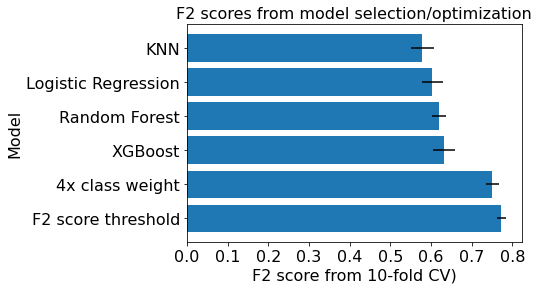

In [60]:
plt.barh(index, values, xerr=std)
#plt.errorbar(index, values, xerr=std, fmt='o')
plt.title('F2 scores from model selection/optimization', fontsize=16)
plt.xlabel('F2 score from 10-fold CV)', fontsize=16)
plt.ylabel('Model', fontsize=16)
plt.yticks(index, features, fontsize=16)
plt.xticks(fontsize=16);



## Bootstrapping logistic regression coefficients 

In [34]:
def bootstrapped_logistic_coefs(X, y, n_boot=100):
    '''Returns mean and 95% confidence intervals for boostrapped 
    logistic regression coefficients'''
    coefs = []

    for n in range(n_boot): # loop over the number of bootstraps
        boot = np.random.randint(0, len(y), len(y)) # sample indices of data
        y_boot = y.iloc[boot] # use indexes to return values
        X_boot = X.iloc[boot]

        # scale features
        scalar = StandardScaler()
        X_boot_scaled = scalar.fit_transform(X_boot)

        # logistic regression
        model = LogisticRegression(C=1, 
                        class_weight={1 : 4, 0 : 1}, 
                        solver='liblinear')
        model.fit(X_boot_scaled, y_boot)

        coefs.append(model.coef_)
        
    mean = np.mean(np.array(coefs), axis = 0)
    lower = np.percentile(np.array(coefs), 2.5, axis=0)
    upper = np.percentile(np.array(coefs), 97.5, axis=0)
    return mean, lower, upper

In [35]:
# running boostrapped coeffients

mean_list, lower_list, upper_list = bootstrapped_logistic_coefs(X, y)

In [36]:
# putting raw bootstrapped coefficient results into a DataFrame

boot_coef = pd.DataFrame(ecig_df.iloc[:, 1:].columns, columns=['feature'])
boot_coef['mean'] = mean_list.reshape(-1,1) # mean coefficients
boot_coef['CI_lower'] = lower_list.reshape(-1,1) 
boot_coef['CI_upper'] = upper_list.reshape(-1,1)
boot_coef


,feature,mean,CI_lower,CI_upper
0,smoke_cig,0.367632,0.287929,0.447691
1,cigar,0.201943,0.132064,0.256950
2,other_tob,0.389128,0.329274,0.466004
3,vape_mj,0.686277,0.631053,0.741230
4,grade,0.732939,0.668267,0.802610
5,sex,0.035709,-0.024358,0.098787
6,native,-0.008724,-0.080815,0.062340
7,asian,0.009399,-0.056771,0.080719
8,black,-0.126621,-0.214661,-0.027990
9,pac_island,-0.006832,-0.083333,0.068769


In [37]:
# exponentiating bootstrapped coefficients (to remove the log)

for col in boot_coef.columns[1:]:
    boot_coef[col + "_exp"] = np.exp(boot_coef[col])

In [38]:
# exponentiated coefficient results - grade and vape_mj are at the top

boot_coef

,feature,mean,CI_lower,CI_upper,mean_exp,CI_lower_exp,CI_upper_exp
0,smoke_cig,0.367632,0.287929,0.447691,1.444310,1.333663,1.564695
1,cigar,0.201943,0.132064,0.256950,1.223778,1.141181,1.292981
2,other_tob,0.389128,0.329274,0.466004,1.475694,1.389958,1.593614
3,vape_mj,0.686277,0.631053,0.741230,1.986307,1.879588,2.098516
4,grade,0.732939,0.668267,0.802610,2.081188,1.950853,2.231356
5,sex,0.035709,-0.024358,0.098787,1.036354,0.975936,1.103831
6,native,-0.008724,-0.080815,0.062340,0.991314,0.922364,1.064324
7,asian,0.009399,-0.056771,0.080719,1.009444,0.944810,1.084067
8,black,-0.126621,-0.214661,-0.027990,0.881067,0.806815,0.972398
9,pac_island,-0.006832,-0.083333,0.068769,0.993191,0.920045,1.071189


#### Interpreting logistic regression coefficients  
- Raw coefficients can only tell us about the log odds   
- By taking the exponent of the coefficients, we can transform them into odds:  
>- One unit increase in 'grade' corresponds to a 95.5% increase in odds of e_cig use  
>- One unit increase in 'harm_others' corresponds to 100-74.9 = 25.1% decrease in odds of e-cig use   

- But notice we need to subtract from 1 to get interpretable odds

In [39]:
# subtracting 1 from exponentiated coefficents and multiplying by 100

for col in boot_coef.columns[-3:]:
    boot_coef[col + '_adjust'] = boot_coef[col].apply(lambda x: 
                              (x - 1) * 100)

In [40]:
# sorting in preparation for plotting

boot_coef = boot_coef.sort_values(by='mean_exp')
boot_coef

,feature,mean,CI_lower,CI_upper,mean_exp,CI_lower_exp,CI_upper_exp,mean_exp_adjust,CI_lower_exp_adjust,CI_upper_exp_adjust
19,harm_self,-0.320029,-0.405875,-0.249579,0.726128,0.666393,0.779129,-27.387226,-33.360685,-22.087104
20,harm_others,-0.313991,-0.390249,-0.254442,0.730526,0.676888,0.775349,-26.947447,-32.311191,-22.465116
8,black,-0.126621,-0.214661,-0.027990,0.881067,0.806815,0.972398,-11.893284,-19.318523,-2.760200
18,addictive,-0.072088,-0.133173,-0.014277,0.930449,0.875314,0.985824,-6.955054,-12.468615,-1.417597
15,internet_use,-0.039797,-0.121843,0.049139,0.960984,0.885288,1.050366,-3.901582,-11.471223,5.036623
22,health_seen,-0.038131,-0.109293,0.018607,0.962587,0.896468,1.018781,-3.741327,-10.353200,1.878149
13,TV/stream_ads,-0.009073,-0.070083,0.060446,0.990968,0.932317,1.062310,-0.903150,-6.768312,6.231033
6,native,-0.008724,-0.080815,0.062340,0.991314,0.922364,1.064324,-0.868642,-7.763608,6.432410
9,pac_island,-0.006832,-0.083333,0.068769,0.993191,0.920045,1.071189,-0.680906,-7.995535,7.118860
7,asian,0.009399,-0.056771,0.080719,1.009444,0.944810,1.084067,0.944370,-5.518982,8.406663


#### Plot the coefficients 

In [52]:
index = np.arange(25)
values = boot_coef['mean_exp_adjust']
lower = boot_coef['mean_exp_adjust'] - boot_coef['CI_lower_exp_adjust'] 
upper = boot_coef['CI_upper_exp_adjust']- boot_coef['mean_exp_adjust']
features = boot_coef['feature']

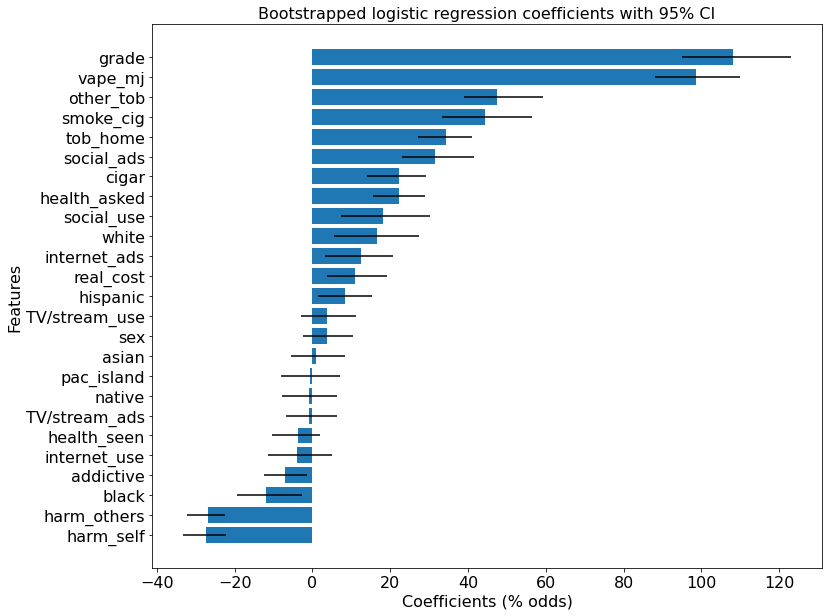

In [57]:
plt.figure(figsize = (12,10))
plt.barh(index, values, xerr=(lower,upper))
plt.title('Bootstrapped logistic regression coefficients with 95% CI', fontsize=16)
plt.xlabel('Coefficients (% odds)', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.yticks(index, features, fontsize=16)
plt.xticks(fontsize=16);

#plt.errorbar(index, values, yerr=(lower, upper));